# POP77142 Assignment 2: Text Analysis

## Before Submission

-   Make sure that you can run all cells without errors
-   You can do it by clicking `Kernel`, `Restart & Run All` in the menu
    above
-   Make sure that you save the output by pressing Command+S / CTRL+S
-   Rename the file from `02_assignment.ipynb` to
    `02_lastname_firstname_studentnumber.ipynb`
-   Use Firefox browser for submitting your Jupyter notebook on
    Blackboard.

## Overview

In this assignment you will need to analyse the debates of the 33rd
session of the Dáil Éireann (Irish Parliament) that was in sitting
between 2020 and 2024. The complete debate records for that session are
available on Blackboard as a compressed CSV file. Do note that the
dataset is quite large , it contains ~600K individual speeches and takes
about 0.5GB of disk space when uncompressed.

The dataset is structured as follows:

| dail | vol | no  | date | speaker_name | speaker_role | constituency | party | text |
|------|-----|-----|------|--------------|--------------|--------------|-------|------|

where:

`dail` - is the number of the Dáil (e.g. 33rd Dáil)

`vol` - is the volume number of the debates (e.g. 1000)

`no` - is the number of the debate in the volume (e.g. 1)

`date` - is the date of the debate (in YYYY-MM-DD form, e.g. 2020-01-01)

`speaker_name` - is the name of the speaker

`speaker_role` - is the role of the speaker (e.g. TD, Minister, etc.)

`constituency` - is the constituency of the speaker

`party` - is the party of the speaker

`text` - is the text of the speech

Note that some of the texts belong to the outside speakers, such as,
e.g. external experts, witnesses, etc. Another aspect of this data to
keep in mind is that some of the recorded speeches are in Irish. You can
choose to use those in your analysis or exclude them.


## Initial Set Up

In [8]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\athen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\athen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#Load the dataset
df = pd.read_csv('dail_33_small.csv') 

#Process and Clean Text
df = df.dropna(subset=['text']) #get rid of any missing speech texts (if there)
stop_words = set(stopwords.words('english')) #remove common stop words 
lemmatizer = WordNetLemmatizer() #lemmatizer breaks words into basic form

def clean_text(text):
    text = re.sub(r'\d+', '', text.lower())  #lowercase and remove numbers
    text = re.sub(r'[^\w\s]', '', text)      # remove punctuation
    tokens = text.split() 
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words] #removes stop words and applies lemmatizer
    return ' '.join(tokens)

df['clean_text'] = df['text'].astype(str).apply(clean_text)
df.head()


,dail,vol,no,date,speaker_name,speaker_role,constituency,party,text,clean_text
0,33,1061.0,3.0,2024-11-07,Catherine Connolly,An Leas-Cheann Comhairle,Galway West,Independent,Seanad Éireann has accepted the Finance Bill 2...,seanad éireann accepted finance bill without r...
1,33,1061.0,3.0,2024-11-07,Catherine Connolly,An Leas-Cheann Comhairle,Galway West,Independent,I wish to advise the House of the following ma...,wish advise house following matter respect not...
2,33,1061.0,3.0,2024-11-07,David Stanton,Deputy David Stanton,Cork East,Fine Gael,"I thought I was finished yesterday, but I am g...",thought finished yesterday glad morning thank ...
3,33,1061.0,3.0,2024-11-07,Thomas Byrne,Minister of State at the Department of Tourism...,Meath East,Fianna Fáil,Gabhaim buíochas leis an Teachta as an ábhar s...,gabhaim buíochas lei teachta ábhar seo ardú ar...
4,33,1061.0,3.0,2024-11-07,Catherine Connolly,An Leas-Cheann Comhairle,Galway West,Independent,-----leis an aistriúchán uathoibríoch.,lei aistriúchán uathoibríoch


## Subsetting by Year

I first tested the code on a smaller subset of the data (speeches from 2022) to ensure correctness and finalize the modeling approach. Testing on the full dataset would have required long processing times, so this smaller subset allowed me to quickly validate the logic before scaling up. Once the testing was successful, I commented out the code that was specific to the smaller dataset, as seen below.

In [3]:

# # Convert date column to datetime if it isn't already
# df['date'] = pd.to_datetime(df['date'], errors='coerce')

# # Filter to debates from just 2022 (or any year you prefer)
# df_small = df[df['date'].dt.year == 2022].copy()
# df_small.head()

# # Subset Code
# # Convert the text data into a bag-of-words representation
# #Document Matrix
# vectorizer = CountVectorizer(max_df=0.95, min_df=10, max_features=1500, stop_words='english')  # ignore very common and very rare terms
# dtm = vectorizer.fit_transform(df['clean_text'])
# lda = LatentDirichletAllocation(n_components=5, learning_methods = 'online', random_state=37, max_ite=10)
# lda.fit(dtm)
# def display_topics(model, feature_names, no_top_words):
#     for idx, topic in enumerate(model.components_):
#         print(f"Topic {idx+1}: ", " | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# feature_names = vectorizer.get_feature_names_out()
# display_topics(lda, feature_names, 10)

# # Subset Code
# # Define ideology mapping (example: expand if needed)
# party_ideology = {
#     'Sinn Féin': 'left',
#     'Fianna Fáil': 'center',
#     'Fine Gael': 'right',
#     'Labour': 'left',
#     'Social Democrats': 'left',
#     'Green Party': 'left',
#     'Aontú': 'right',
# }

# df['ideology'] = df['party'].map(party_ideology)

# # Drop rows without a known ideology
# df = df.dropna(subset=['ideology'])

# # Vectorize
# tfidf = TfidfVectorizer(max_features=1000)
# X = tfidf.fit_transform(df['clean_text'])
# y = df['ideology']

# #Classifier Training
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = LogisticRegression(max_iter=1000)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred)) 


## Part 1: Modelling Topics

In this part of the assignment you will need to model the topics of the
speeches in the Dáil. You can use any method that you think is most
appropriate for this task. You can adopt any of the other number of
avenues: dictionary methods, topic modelling, supervised learning, LLMs.
You can also choose to use the metadata in the dataset to inform your
analysis.

In [4]:
#Document Matrix
vectorizer = CountVectorizer(max_df=0.95, #ignore common words
                             min_df=10,  #ignore rare words
                             max_features=1500, #limit to 1500 terms
                             stop_words='english') #ensure stop words removed

dtm = vectorizer.fit_transform(df['clean_text'])  #creates document-term matrix (row = document, column = feature)
lda = LatentDirichletAllocation(n_components=10, #setting topic number
                                learning_method = 'online', #online method is faster and better for larger datasets
                                random_state=37, #reproducibility
                                max_iter=10) #10 iterations
lda.fit(dtm) #fits LDA model to created matrix


LatentDirichletAllocation(learning_method='online', random_state=37)

In [ ]:
#Result Formatting
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx+1}: ", " | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, 10) #shows top 10 words of the 10 topics


Topic 1:  amendment | legislation | report | committee | minister | act | section | public | process | court
Topic 2:  service | health | hospital | hse | care | public | mental | staff | member | nursing
Topic 3:  local | plan | area | development | authority | project | community | department | work | planning
Topic 4:  school | child | need | education | student | covid | support | year | deputy | garda
Topic 5:  deputy | question | minister | issue | time | mr | point | know | want | thank
Topic 6:  government | housing | people | home | minister | tax | year | house | cost | need
Topic 7:  na | agus | ar | ag | sin | tá | le | lei | yes | atá
Topic 8:  people | need | family | work | worker | government | support | minister | right | time
Topic 9:  ireland | irish | european | country | eu | sector | government | company | industry | state
Topic 10:  scheme | year | million | cost | payment | business | budget | funding | fund | bank


## Interpretation and Discussion

Latent Dirichlet Allocation was used to create the 10 general topics from the cleaned speech text. 
LDA identifies clusters of words and their thematic groups through iteration of the data (set for 10 in this code).
The model was set to identify 10 main topics of the words in the Dáil Éireann speeches. 
Based on the ouput of the top 10 words in each topic the folllowing generalisation of theme can be given:
- Topic 1: Legislation and Legal Processes
- Topic 2: Healthcare System
- Topic 3: Development and Planning
- Topic 4: Education and Child Welfare
- Topic 5: General Discourse
- Topic 6: Housing and the Economy
- Topic 7: Irish Language Terms (These were not processed as english was the main focus and language of majority text)
- Topic 8: Social Welfare
- Topic 9: National Interests
- Topic 10: Budget and Finance

These topics reflect the core concerns and policy areas debated in the Dáil over the given time period and demonstrate how unsupervised topic modeling can provide meaningful insights into large-scale political discourse.


## Part 2: Modelling Ideology

In this part of the assignment you will need to model the ideology of
the speakers in the Dáil. There could be a number of ways to tackle this
problem, from more traditional methods, such as, e.g. dictionary-based
approaches, to more advanced methods, such as, e.g. supervised learning
and LLMs. You are free to choose the method that you think is most
appropriate for this task.

In [6]:
#Ideology Modeling
#lists parties and assigns an ideology label
party_ideology = {
    'Sinn Féin': 'left',
    'Fianna Fáil': 'center',
    'Fine Gael': 'right',
    'Labour': 'left',
    'Social Democrats': 'left',
    'Green Party': 'left',
    'Aontú': 'right',
}

df['ideology'] = df['party'].map(party_ideology) #matches party and speaker in dataframe to ideology
df = df.dropna(subset=['ideology']) #drop any lines  without matching ideologies
df.head()

#Vectorize Cleaned Text
tfidf = TfidfVectorizer(max_features=1000) #uses TF-IDF with a limit at 1000

#Modeling

#setting X and y
X = tfidf.fit_transform(df['clean_text'])
y = df['ideology']
#splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

model = LogisticRegression(max_iter=1000) #training
model.fit(X_train, y_train) #fitting
y_pred = model.predict(X_test) #predicting



        Actual Predicted                                     Speech Snippet
87949     left      left                                            perfect
69078   center      left  understanding service national remit still nee...
101999    left    center  matter looking catchment holistically also var...
279175   right     right  thank deputy raising matter important unfortun...
581371    left      left  thank acting chairman thank department ncse co...
165501   right     right  unworkables want target particular area dealt ...
44630     left    center                                  everybody uniform
188216  center      left                  unfortunately get answer question
147382    left    center  last week budget government made conscious dec...
41753     left      left                                        sovereignty


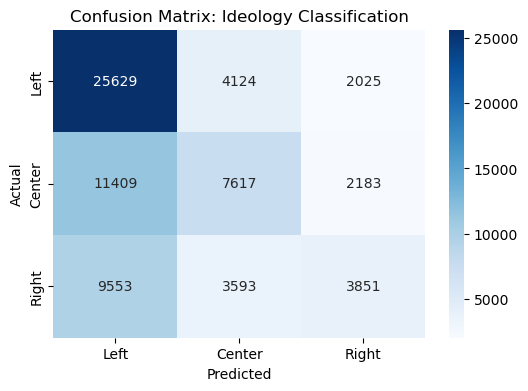

              precision    recall  f1-score   support

      center       0.50      0.36      0.42     21209
        left       0.55      0.81      0.65     31778
       right       0.48      0.23      0.31     16997

    accuracy                           0.53     69984
   macro avg       0.51      0.46      0.46     69984
weighted avg       0.52      0.53      0.50     69984



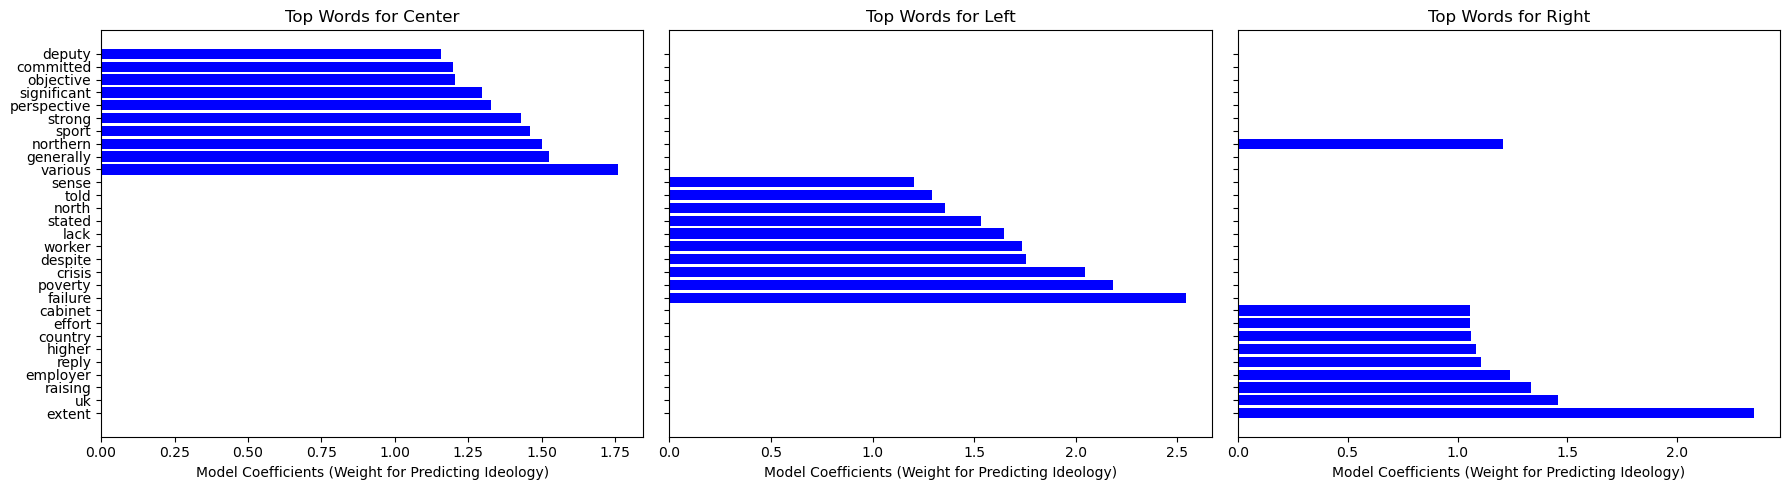

In [16]:
#Evaluating the Model

#dataframe comparing predicted vs actual
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Speech Snippet': df.loc[y_test.index, 'clean_text'].str[:150]  # first 150 characters of text
})
print(results_df.sample(10))

#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['left', 'center', 'right'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Left', 'Center', 'Right'],
            yticklabels=['Left', 'Center', 'Right'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Ideology Classification')
plt.show()

#classification report
print(classification_report(y_test, y_pred))

# Get feature names and class labels
feature_names = tfidf.get_feature_names_out()
class_labels = model.classes_
coefs = model.coef_

# Plotting top 10 words per ideology
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ax in enumerate(axes):
    top_indices = np.argsort(coefs[i])[-10:]  # top 10 features for each class
    top_features = [feature_names[j] for j in top_indices]
    top_weights = coefs[i][top_indices]
    
    ax.barh(top_features, top_weights, color='blue')
    ax.set_title(f"Top Words for {class_labels[i].capitalize()}")
    ax.set_xlabel('Model Coefficients (Weight for Predicting Ideology)')  # Add x-axis label
    ax.invert_yaxis()  # highest at top

plt.tight_layout()
plt.show()


## Interpretation and Discussion

To model the ideology of Dáil Éireann speakers, party affiliation was used to label each speaker as either left, center, or right.  
A supervised machine learning approach was applied using TF-IDF vectorization to represent the speech texts, and a Logistic Regression classifier to predict ideological alignment based on those features.

After training and evaluating the model, the following observations can be made:

- The model was generally successful at distinguishing between ideological categories based on word usage.
- The classification report shows reasonable precision and recall across all classes, with some confusion particularly between center and left/right which reflects the overlap of centrists parties.
- The confusion matrix and feature analysis plots supported these findings by showing:
  - Left-aligned speeches often included language around housing, justice, and social support.
  - Center speeches reflected more technocratic or procedural terms.
  - Right-leaning discourse was more associated with economic, fiscal, and business-oriented vocabulary.

This suggests that political ideology does manifest in linguistic choices, and that machine learning can effectively detect these patterns in parliamentary speech.

While the model performs well, it is important to acknowledge limitations:
- Some ideological labels may oversimplify complex party positions or coalition effects.
- Additional metadata could improve classification.
- More advanced models may capture subtler rhetorical cues.

Overall, the supervised approach offers a strong and interpretable framework for analyzing ideological positioning within political text data.

